<a href="https://colab.research.google.com/github/deysohom99/Separation-of-Arteriovenous-Trees-from-Retinal_Fundus-Images/blob/master/miou_0.6462.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Thu Apr  2 12:49:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import cv2
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, Activation, Lambda, concatenate, MaxPooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from albumentations import (Compose, OneOf, Flip, Transpose, ShiftScaleRotate, Rotate, RandomRotate90, OpticalDistortion, GridDistortion, 
                            ElasticTransform, IAAPiecewiseAffine, RGBShift, ChannelShuffle, RandomBrightnessContrast, RandomGamma, CLAHE, RandomCrop)
from sklearn.metrics import classification_report, roc_auc_score

In [0]:
%%capture
!wget http://webeye.ophth.uiowa.edu/abramoff/AV_groundTruth.zip
!unzip AV_groundTruth.zip 
os.remove('AV_groundTruth.zip')

In [0]:
train_img_files = sorted(['AV_groundTruth/training/images/' + i for i in os.listdir('AV_groundTruth/training/images')])
train_msk_files = sorted(['AV_groundTruth/training/av/' + i for i in os.listdir('AV_groundTruth/training/av')])

valid_img_files = sorted(['AV_groundTruth/test/images/' + i for i in os.listdir('AV_groundTruth/test/images')])
valid_msk_files = sorted(['AV_groundTruth/test/av/' + i for i in os.listdir('AV_groundTruth/test/av')])

In [13]:
def read_image(file_loc):

  img = np.array(Image.open(file_loc))
  
  return img

ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [0]:
def read_mask(file_loc):

  msk1 = np.array(Image.open(file_loc).convert('L'))/255
  msk1 = (msk1>0.1).astype(np.uint8)

  msk2 = np.array(Image.open(file_loc))//255

  r = msk2[:,:,0] + msk2[:,:,1]
  r[np.where(r==2)] = 0
  b = msk2[:,:,2] + msk2[:,:,1]
  b[np.where(b==2)] = 0
  msk2 = np.dstack([r,b])

  msk = np.dstack([msk1, msk2])
  
  return msk

In [0]:
class Train_Generator(Sequence):

  augmentations = Compose(
  [
    OneOf([
            Flip(),
            Transpose()
    ], p=0.9),
    OneOf([  
            ShiftScaleRotate(),
            Rotate(),
            RandomRotate90(),
    ], p=0.9),
    OneOf([
            OpticalDistortion(),
            GridDistortion(),
            ElasticTransform(),
            IAAPiecewiseAffine()
    ], p=0.6),
    RandomCrop(height=256, width=256, always_apply=True, p=1.0),
    OneOf([
            RGBShift(),
            RandomBrightnessContrast(),
            RandomGamma()
          ], p=0.2),
    CLAHE(always_apply=True, p=1.0),
  ]) 

  def __init__(self, x_set, y_set, batch_size):
    self.x = x_set
    self.y = y_set
    self.batch_size = batch_size

  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)


  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    batch_x = np.array([read_image(file_name) for file_name in batch_x])
    batch_y = np.array([read_mask(file_name) for file_name in batch_y])

    aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
    batch_x = np.array([i['image'] for i in aug])
    batch_y = np.array([j['mask'] for j in aug])

    batch_y1 = np.expand_dims(batch_y[:, :, :, 0], -1)
    batch_y2 = batch_y[:, :, :, 1:]

    return batch_x/255, [batch_y1/1.0, batch_y2/1.0]

#-------------------------------------------------------------------------------
class Valid_Generator(Sequence):

  augmentations = Compose(
  [
    RandomCrop(height=256, width=256, always_apply=True, p=1.0),
    CLAHE(always_apply=True, p=1.0)
  ])
  

  def __init__(self, x_set, y_set, batch_size):
    self.x = x_set
    self.y = y_set
    self.batch_size = batch_size

  def __len__(self):
    return math.ceil(len(self.x) / self.batch_size)


  def __getitem__(self, idx):
    batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
    batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

    batch_x = np.array([read_image(file_name) for file_name in batch_x])
    batch_y = np.array([read_mask(file_name) for file_name in batch_y])

    aug = [self.augmentations(image=i, mask=j) for i, j in zip(batch_x, batch_y)]
    batch_x = np.array([i['image'] for i in aug])
    batch_y = np.array([j['mask'] for j in aug])

    batch_y1 = np.expand_dims(batch_y[:, :, :, 0], -1)
    batch_y2 = batch_y[:, :, :, 1:]

    return batch_x/255, [batch_y1/1.0, batch_y2/1.0]

In [0]:
train_generator = Train_Generator(train_img_files*100, train_msk_files*100, 5)
valid_generator = Valid_Generator(valid_img_files*100, valid_msk_files*100, 5)

In [0]:
for i, j in valid_generator:
    break
j1 = j[0]
j2 = j[1]

In [19]:
print(i.shape)
print(j1.shape)
print(j2.shape)

(5, 256, 256, 3)
(5, 256, 256, 1)
(5, 256, 256, 2)


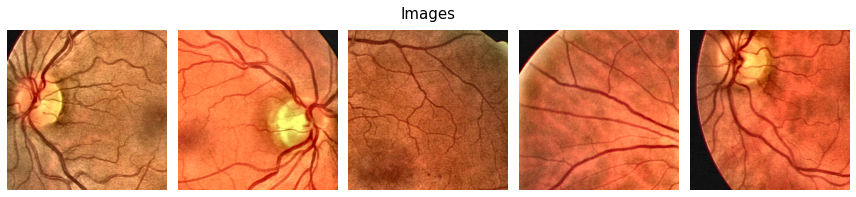

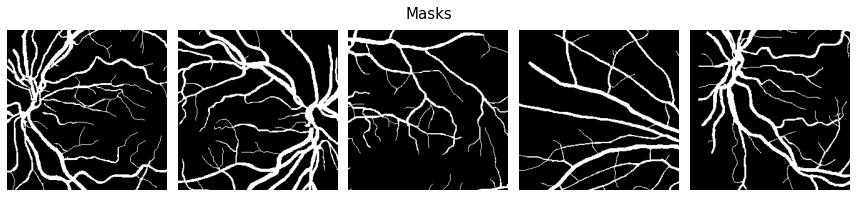

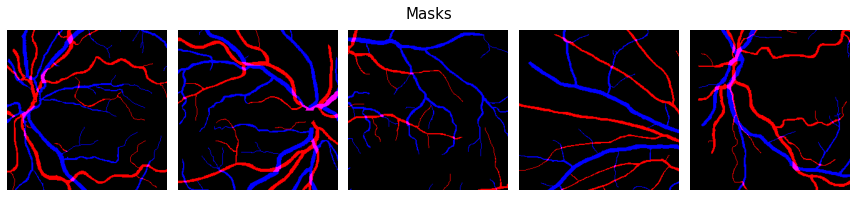

In [20]:
fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j1[:5], axes[:5]):
    ax.imshow(np.squeeze(img, -1), cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j2[:5], axes[:5]):
    ax.imshow(np.dstack([img[:,:,0], np.zeros_like(img[:,:,0]), img[:,:,1]]))
    ax.axis('off')
plt.tight_layout()
plt.show()

In [0]:
def dice_loss(y_true, y_pred):
  intersection = tf.reduce_sum(y_true * y_pred) + 1.0
  dice_score = (2. * intersection + 1.0) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1.0)
  dice_loss = 1. - dice_score
  return dice_loss

def bce_dice_loss(y_true, y_pred):
  return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def iou(y_true, y_pred):
  y_true = tf.cast(y_true>0.5, tf.float32)
  y_pred = tf.cast(y_pred>0.5, tf.float32)
  intersection = tf.reduce_sum(y_true * y_pred) + 1.0
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.0
  iou = intersection/union
  return iou

def miou(y_true, y_pred):
  y_true = tf.cast(y_true>0.5, tf.float32)
  y_pred = tf.cast(y_pred>0.5, tf.float32)
  miou = 0.0
  for i in range(2):
    intersection = tf.reduce_sum(y_true[:,:,:,i] * y_pred[:,:,:,i]) + 1.0
    union = tf.reduce_sum(y_true[:,:,:,i]) + tf.reduce_sum(y_pred[:,:,:,i]) - intersection + 1.0
    iou = intersection/union
    miou += iou
  miou = miou/2
  return miou

earlystopping = EarlyStopping(
  monitor='val_loss', 
  min_delta=0, 
  patience=7, 
  verbose=1, 
  restore_best_weights=True)

reducelr = ReduceLROnPlateau(
  monitor='val_loss', 
  factor=0.1, 
  patience=3, 
  verbose=1,  
  min_delta=0.0001 )

callbacks = [earlystopping, reducelr]

In [0]:
#-------------------------------------------------------------------------------
def SubpixelDownsampling(x, block_name=''):
  # Convert H,W,C - H/2,W/2,C*2
  depth = tf.keras.backend.int_shape(x)[-1]
  def space_to_depth(x):
        return tf.nn.space_to_depth(x, 2)
  x = Conv2D(filters=depth//2, kernel_size=(1,1), strides=1, padding='same', name=block_name+'_conv_sp')(x)
  x = Lambda(space_to_depth, name=block_name+'_shuffle_sp')(x)
  return x

def SubpixelUpsampling(x, block_name=''):
  # Convert H,W,C - H*2,W*2,C/2
  depth = tf.keras.backend.int_shape(x)[-1]
  def depth_to_space(x):
        return tf.nn.depth_to_space(x, 2)
  x = Conv2D(filters=depth*2, kernel_size=(1,1), strides=1, padding='same', name=block_name+'_conv_sp')(x)
  x = Lambda(depth_to_space, name=block_name+'shuffle_sp')(x)
  return x

#-------------------------------------------------------------------------------
def ResidualBlock(input_tensor, filters, strides, block_name=''):

  skip = input_tensor
  main = input_tensor

  if strides==2:
    skip = SubpixelDownsampling(skip, block_name+'_skip')
    main = SubpixelDownsampling(main, block_name+'_main')

  main = Conv2D(filters=filters, kernel_size=(3,3), strides=1, padding='same', name=block_name+'_conv1')(main)
  main = BatchNormalization(name=block_name+'_bn_1')(main)
  main = Activation('relu', name=block_name+'_relu')(main)

  main = Conv2D(filters=filters, kernel_size=(3,3), strides=1, padding='same', name=block_name+'_conv2')(main)
  main = BatchNormalization(name=block_name+'_bn_2')(main)

  out = Add(name=block_name+'_add')([main, skip])
  out = Activation('relu', name=block_name+'_relu_out')(out)

  return out

#-------------------------------------------------------------------------------

In [0]:

def get_model():

  inputs = Input((None,None,3))

  x0 = Conv2D(filters=36, activation='relu', kernel_size=(7,7), strides=1, padding='same', name='Block0')(inputs)

  x1 = ResidualBlock(x0, 36, strides=1, block_name='Block1')
  x1 = ResidualBlock(x1, 36, strides=1, block_name='Block2')

  x2 = ResidualBlock(x1, 72, strides=2, block_name='Block3')
  x2 = ResidualBlock(x2, 72, strides=1, block_name='Block4')

  x3 = ResidualBlock(x2, 144, strides=2, block_name='Block5')
  x3 = ResidualBlock(x3, 144, strides=1, block_name='Block6')

  x4 = ResidualBlock(x3, 288, strides=2, block_name='Block7')
  x4 = ResidualBlock(x4, 288, strides=1, block_name='Block8')

  x5 = ResidualBlock(x4, 576, strides=2, block_name='Block9')
  x5 = ResidualBlock(x5, 576, strides=1, block_name='Block10')

  y4 = SubpixelUpsampling(x5, block_name='UP1')
  y4 = concatenate([y4, x4])
  y4 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y4)
  y4 = BatchNormalization() (y4)
  y4 = Conv2D(288, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y4)
  y4 = BatchNormalization() (y4)

  y3 = SubpixelUpsampling(y4, block_name='UP2')
  y3 = concatenate([y3, x3])
  y3 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y3)
  y3 = BatchNormalization() (y3)
  y3 = Conv2D(144, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y3)
  y3 = BatchNormalization() (y3)

  y2 = SubpixelUpsampling(y3, block_name='UP3')
  y2 = concatenate([y2, x2])
  y2 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y2)
  y2 = BatchNormalization() (y2)
  y2 = Conv2D(72, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y2)
  y2 = BatchNormalization() (y2)

  y1 = SubpixelUpsampling(y2, block_name='UP4')
  y1 = concatenate([y1, x1])
  y1 = Conv2D(36, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y1)
  y1 = BatchNormalization() (y1)
  y1 = Conv2D(36, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (y1)
  y1 = BatchNormalization() (y1)

  outputs =  Conv2D(2, (1, 1), activation='sigmoid') (y1)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [0]:
K.clear_session()
model = get_model()

In [0]:
class conv_bnorm(tf.keras.layers.Layer):

  def __init__(self, f, **kwargs):
    super(conv_bnorm, self).__init__(**kwargs)
    self.conv_1 = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.norm_1 = BatchNormalization()
    self.conv_2 = Conv2D(f, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')
    self.norm_2 = BatchNormalization()

  def call(self, inputs):
    x = self.conv_1(inputs)
    x = self.norm_1(x)
    x = self.conv_2(x)
    x = self.norm_2(x)
    return x


def SubpixelUpsampling(x, y):
    depth = tf.keras.backend.int_shape(x)[-1]
    def depth_to_space(x):
          return tf.nn.depth_to_space(x, 2)
    x = Conv2D(filters=depth*2, kernel_size=(1,1), strides=1, padding='same', )(x)
    x = Lambda(depth_to_space)(x)
    x = concatenate([x, y])
    return x

In [0]:
K.clear_session()


inputs = Input((256,256,3), name='Input')

m1c1 = conv_bnorm(32, name='M1_conv_bnorm_d1') (inputs)
m1p1 = MaxPooling2D(name='M1_pool1') (m1c1)

m1c2 = conv_bnorm(64, name='M1_conv_bnorm_d2') (m1p1)
m1p2 = MaxPooling2D(name='M1_pool2') (m1c2)

m1c3 = conv_bnorm(128, name='M1_conv_bnorm_d3') (m1p2)
m1p3 = MaxPooling2D(name='M1_pool3') (m1c3)

m1c4 = conv_bnorm(256, name='M1_conv_bnorm_d4') (m1p3)
m1p4 = MaxPooling2D(name='M1_pool4') (m1c4)

m1c5 = conv_bnorm(512, name='M1_conv_bnorm_d5') (m1p4)
m1p5 = MaxPooling2D(name='M1_pool5') (m1c5)

m1c6 = conv_bnorm(1024, name='M1_conv_bnorm_d6') (m1p5)

m1u5 = SubpixelUpsampling(m1c6, m1c5)
m1u5 = conv_bnorm(512, name='M1_conv_bnorm5_u5') (m1u5)

m1u4 = SubpixelUpsampling(m1u5, m1c4)
m1u4 = conv_bnorm(256, name='M1_conv_bnorm_u4') (m1u4)

m1u3 = SubpixelUpsampling(m1u4, m1c3)
m1u3 = conv_bnorm(128, name='M1_conv_bnorm_u3') (m1u3)

m1u2 = SubpixelUpsampling(m1u3, m1c2)
m1u2 = conv_bnorm(256, name='M1_conv_bnorm_u2') (m1u2)

m1u1 = SubpixelUpsampling(m1u2, m1c1)
m1u1 = conv_bnorm(32, name='M1_conv_bnorm_u1') (m1u1)

m1out = Conv2D(1, (1, 1), name='M1_output', activation='sigmoid') (m1u1)


#-----------------------------------------------------------------------------


m2inp = concatenate([m1u1, inputs])

m2c1 = conv_bnorm(32, name='M2_conv_bnorm_d1') (m2inp)
m2p1 = MaxPooling2D(name='M2_pool1') (m2c1)

m2c2 = conv_bnorm(64, name='M2_conv_bnorm_d2') (m2p1)
m2p2 = MaxPooling2D(name='M2_pool2') (m2c2)

m2c3 = conv_bnorm(128, name='M2_conv_bnorm_d3') (m2p2)
m2p3 = MaxPooling2D(name='M2_pool3') (m2c3)

m2c4 = conv_bnorm(256, name='M2_conv_bnorm_d4') (m2p3)
m2p4 = MaxPooling2D(name='M2_pool4') (m2c4)

m2c5 = conv_bnorm(512, name='M2_conv_bnorm_d5') (m2p4)
m2p5 = MaxPooling2D(name='M2_pool5') (m2c5)

m2c6 = conv_bnorm(1024, name='M2_conv_bnorm_d6') (m2p5)

m2u5 = SubpixelUpsampling(m2c6, m2c5)
m2u5 = concatenate([m2u5, m1u5])
m2u5 = conv_bnorm(512, name='M2_conv_bnorm_u5') (m2u5)

m2u4 = SubpixelUpsampling(m2c5, m2c4)
m2u4 = concatenate([m2u4, m1u4])
m2u4 = conv_bnorm(256, name='M2_conv_bnorm_u4') (m2u4)

m2u3 = SubpixelUpsampling(m2u4, m2c3)
m2u3 = concatenate([m2u3, m2u3])
m2u3 = conv_bnorm(128, name='M2_conv_bnorm_u3') (m2u3)

m2u2 = SubpixelUpsampling(m2u3, m2c2)
m2u2 = concatenate([m2u2, m1u2])
m2u2 = conv_bnorm(256, name='M2_conv_bnorm_u2') (m2u2)

m2u1 = SubpixelUpsampling(m2u2, m2c1)
m2u1 = concatenate([m2u1, m1u1])
m2u1 = conv_bnorm(32, name='M2_conv_bnorm_u1') (m2u1)

m2out = Conv2D(2, (1, 1), name='M2_output', activation='sigmoid') (m2u1)


#-----------------------------------------------------------------------------

model = Model(inputs=[inputs], outputs=[m1out, m2out])

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
M1_conv_bnorm_d1 (conv_bnorm)   (None, 256, 256, 32) 10400       Input[0][0]                      
__________________________________________________________________________________________________
M1_pool1 (MaxPooling2D)         (None, 128, 128, 32) 0           M1_conv_bnorm_d1[0][0]           
__________________________________________________________________________________________________
M1_conv_bnorm_d2 (conv_bnorm)   (None, 128, 128, 64) 55936       M1_pool1[0][0]                   
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss=[bce_dice_loss, bce_dice_loss], metrics={'M1_output':iou, 'M2_output':miou})

In [26]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data = valid_generator,
    validation_steps = len(valid_generator),
    callbacks=callbacks,
    verbose=1
    )

Epoch 1/100
400/400 [==============================] - 860s 2s/step - loss: 1.5232 - M1_output_loss: 0.6133 - M2_output_loss: 0.9099 - M1_output_iou: 0.5780 - M2_output_miou: 0.3499 - val_loss: 1.0844 - val_M1_output_loss: 0.4235 - val_M2_output_loss: 0.6609 - val_M1_output_iou: 0.6191 - val_M2_output_miou: 0.3362 - lr: 0.0010
Epoch 2/100
400/400 [==============================] - 846s 2s/step - loss: 0.9682 - M1_output_loss: 0.4156 - M2_output_loss: 0.5526 - M1_output_iou: 0.6276 - M2_output_miou: 0.4379 - val_loss: 0.8539 - val_M1_output_loss: 0.3318 - val_M2_output_loss: 0.5221 - val_M1_output_iou: 0.6967 - val_M2_output_miou: 0.4608 - lr: 0.0010
Epoch 3/100
400/400 [==============================] - 856s 2s/step - loss: 0.8745 - M1_output_loss: 0.4008 - M2_output_loss: 0.4737 - M1_output_iou: 0.6357 - M2_output_miou: 0.5005 - val_loss: 0.7451 - val_M1_output_loss: 0.3168 - val_M2_output_loss: 0.4283 - val_M1_output_iou: 0.7052 - val_M2_output_miou: 0.5407 - lr: 0.0010
Epoch 4/100
4

In [27]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
os.mkdir('drive/My Drive/Retina_AV')

In [0]:
valid_generator = Valid_Generator(valid_img_files, valid_msk_files, 1)

x_val = []
y_val = []
p_val = []

for x, y in valid_generator:
  p = model.predict(x)[1]
  x_val.append(np.squeeze(x, 0))
  y_val.append(np.squeeze(y[1], 0))
  p_val.append(np.squeeze(p, 0))

x_val = np.array(x_val)
y_val = np.array(y_val)
p_val = np.array(p_val)

In [0]:
def calc_score(y_true, y_pred):
  report = classification_report((y_true).flatten(), (y_pred).flatten(), output_dict=True)
  Accuracy = report['accuracy']
  Precision = report['True']['precision']
  Recall = report['True']['recall']
  F1_score = report['True']['f1-score']
  Sensitivity = report['True']['recall']
  Specificity = report['False']['recall']
  AUC = roc_auc_score(y_true.flatten(), y_pred.flatten())
  IOU = (Precision*Recall)/(Precision+Recall-Precision*Recall)
  return [Accuracy, Precision, Recall, F1_score, Sensitivity, Specificity, AUC, IOU]

def print_score(scores):
  '''
  scores = [Accuracy, Precision, Recall, F1_score, Sensitivity, Specificity, AUC, IOU]
  '''
  print('Accuracy\t:\t{0:.4f}'.format(scores[0]))
  print('Precision\t:\t{0:.4f}'.format(scores[1]))
  print('Recall\t\t:\t{0:.4f}'.format(scores[2]))
  print('F1_score\t:\t{0:.4f}'.format(scores[3]))
  print('Sensitivity\t:\t{0:.4f}'.format(scores[4]))
  print('Specificity\t:\t{0:.4f}'.format(scores[5]))
  print('AUC\t\t:\t{0:.4f}'.format(scores[6]))
  print('IOU\t\t:\t{0:.4f}'.format(scores[7]))

In [56]:
scores = []
for i in range(2):
  y_true = y_val[:,:,:,i]
  y_pred = p_val[:,:,:,i]
  score = calc_score(y_true>0.5, y_pred>0.5)
  scores.append(score)
  print_score(score)
  print('\n\n')
scores = np.array(scores)

Accuracy	:	0.9757
Precision	:	0.8038
Recall		:	0.7590
F1_score	:	0.7808
Sensitivity	:	0.7590
Specificity	:	0.9888
AUC		:	0.8739
IOU		:	0.6404



Accuracy	:	0.9729
Precision	:	0.8298
Recall		:	0.7526
F1_score	:	0.7893
Sensitivity	:	0.7526
Specificity	:	0.9888
AUC		:	0.8707
IOU		:	0.6520





In [57]:
mean_score = np.mean(scores, axis=0)
print_score(mean_score)

Accuracy	:	0.9743
Precision	:	0.8168
Recall		:	0.7558
F1_score	:	0.7850
Sensitivity	:	0.7558
Specificity	:	0.9888
AUC		:	0.8723
IOU		:	0.6462


In [0]:
model.save_weights('drive/My Drive/Retina_AV/iou_0.6462.h5')

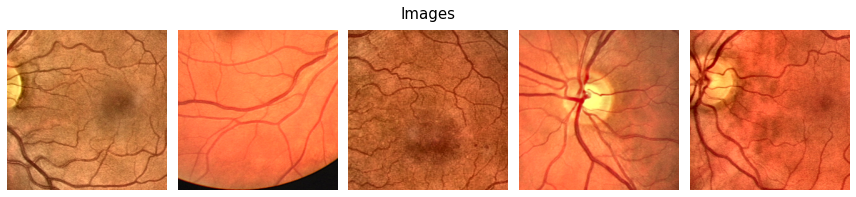

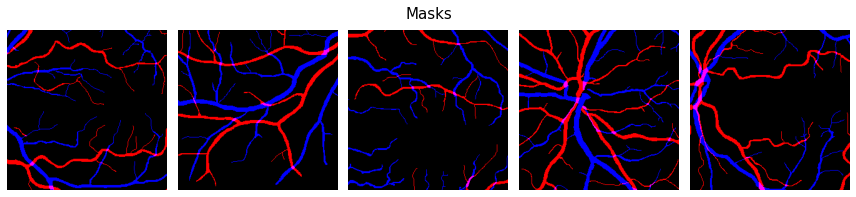

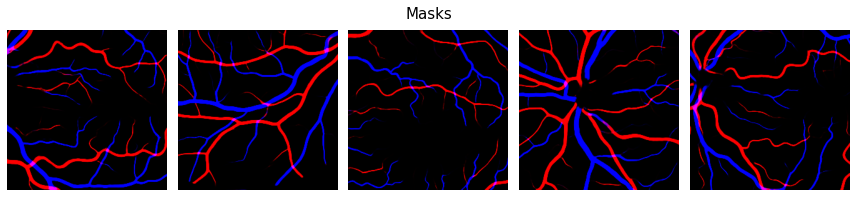

In [55]:
fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(x_val[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(y_val[:5], axes[:5]):
    ax.imshow(np.dstack([img[:,:,0], np.zeros_like(img[:,:,0]), img[:,:,1]]))
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(p_val[:5], axes[:5]):
    ax.imshow(np.dstack([img[:,:,0], np.zeros_like(img[:,:,0]), img[:,:,1]]))
    ax.axis('off')
plt.tight_layout()
plt.show()